In [111]:
%matplotlib notebook

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

# plt.rcParams['figure.figsize'] = (15,15)
# plt.rcParams.update({'font.size': 12})

In [112]:
# hard-coded parameters corresponding to test conditions,
# because my code is poorly planned out
NPOS_TEST = 6000
NNEG_TEST = 3457
NTRAINING = 6000

CSV_GENRESULT_FILE = 'hogsvm_result_all_30March2020.csv'
CSV_POST_FALSE_IMAGE_FILE = 'hogsvm_result_all_false_images.csv'
CSV_POST_PERFORMANCE_FILE = 'hogsvm_result_all_performance.csv'

In [113]:
df = pd.read_csv(CSV_GENRESULT_FILE)
df

,Test,Cells per Block,Pixels per Cell,Orientations,Feature Size,AUC,Accuracy,Precision,Recall,Training Accuracy,Prediction Time (s),TP,TN,FP,FN
0,1,1,4,6,1920,0.996012,0.974410,0.974472,0.974410,1.000000,0.382794,3350,5865,135,107
1,2,1,4,8,2560,0.997329,0.978640,0.978680,0.978640,1.000000,0.438810,3367,5888,112,90
2,3,1,4,9,2880,0.996937,0.978323,0.978361,0.978323,1.000000,0.522411,3365,5887,113,92
3,4,1,4,10,3200,0.997586,0.980332,0.980374,0.980332,1.000000,0.573908,3376,5895,105,81
4,5,1,4,12,3840,0.997873,0.980755,0.980816,0.980755,1.000000,0.671648,3382,5893,107,75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,156,4,14,6,192,0.986252,0.945332,0.946838,0.945332,0.956500,0.031246,3299,5641,359,158
156,157,4,14,8,256,0.991834,0.955588,0.956980,0.955588,0.964667,0.054459,3347,5690,310,110
157,158,4,14,9,288,0.992339,0.957809,0.959059,0.957809,0.968667,0.046865,3352,5706,294,105
158,159,4,14,10,320,0.993277,0.959818,0.961039,0.959818,0.968667,0.046867,3361,5716,284,96


### Minimise Miss Rate

In [114]:
# parameters to minimise people not being identified (FN)
# * Precision = TP/(TP+FP)  <--- classified P
# * Recall    = TP/(TP+FN)  <--- actually P

df['Miss Rate'] = df['FN'] / (df['TP'] + df['FN'])   # MR = (1 - Recall)
df.loc[df['FN'].idxmin()]

Test                      85.000000
Cells per Block            3.000000
Pixels per Cell            4.000000
Orientations              12.000000
Feature Size           27216.000000
AUC                        0.999455
Accuracy                   0.989955
Precision                  0.989992
Recall                     0.989955
Training Accuracy          1.000000
Prediction Time (s)        5.089444
TP                      3424.000000
TN                      5938.000000
FP                        62.000000
FN                        33.000000
Miss Rate                  0.009546
Name: 84, dtype: float64

In [115]:
# parameters to maximise Accuracy
max_accuracy_row = df.loc[df['Accuracy'].idxmax()]
best_orientations = max_accuracy_row.get(key='Orientations')
max_accuracy_row # (same as the row with min FN? (i.e. same orientations))

Test                      85.000000
Cells per Block            3.000000
Pixels per Cell            4.000000
Orientations              12.000000
Feature Size           27216.000000
AUC                        0.999455
Accuracy                   0.989955
Precision                  0.989992
Recall                     0.989955
Training Accuracy          1.000000
Prediction Time (s)        5.089444
TP                      3424.000000
TN                      5938.000000
FP                        62.000000
FN                        33.000000
Miss Rate                  0.009546
Name: 84, dtype: float64

In [116]:
# parameters to maximise AUC
df.loc[df['AUC'].idxmax()] # (also the same row)

Test                      85.000000
Cells per Block            3.000000
Pixels per Cell            4.000000
Orientations              12.000000
Feature Size           27216.000000
AUC                        0.999455
Accuracy                   0.989955
Precision                  0.989992
Recall                     0.989955
Training Accuracy          1.000000
Prediction Time (s)        5.089444
TP                      3424.000000
TN                      5938.000000
FP                        62.000000
FN                        33.000000
Miss Rate                  0.009546
Name: 84, dtype: float64

In [117]:
# https://matplotlib.org/3.1.1/gallery/mplot3d/3d_bars.html
# https://stackoverflow.com/questions/9433240/python-matplotlib-3d-bar-plot-adjusting-tick-label-position-transparent-b/9464391
# https://stackoverflow.com/questions/43869751/change-bar-color-in-a-3d-bar-plot-in-matplotlib-based-on-value
# https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html

def str_dim(l):
    return tuple(map(lambda v: '{0}x{0}'.format(v), l))

def plot_bar3d(x_labels, y_labels, dz_np, z_lim_min, z_lim_max, 
               x_title, y_title, z_title, fig_title, ztick_increment=0.5):
    # (x,y,z) coordinates of each bar
    x = list(range(len(x_labels))) * int(len(dz_np)/len(x_labels))
    y = [v for v in list(range(len(y_labels))) for i in range(int(len(dz_np)/len(y_labels)))]
    z = [0] * len(dz_np)
    # (width,depth,height) of each bar
    thickness = 0.4
    dx = [thickness] * len(dz_np)
    dy = [thickness] * len(dz_np)
    dz = list(dz_np)

    colors = plt.cm.jet(dz_np/dz_np.max())

    fig = plt.figure() # OOP style
    ax1 = fig.add_subplot(111, projection='3d')
    ax1.bar3d(x,y,z,dx,dy,dz,color=colors)

    tick_offset = thickness/2
    #ztick_increment = 0.5
    ticksx = np.arange(tick_offset, len(x_labels), 1)
    ax1.set_xticks(ticksx)
    ax1.set_xticklabels(x_labels)
    ticksy = np.arange(tick_offset, len(y_labels), 1)
    ax1.set_yticks(ticksy)
    ax1.set_yticklabels(y_labels)
    ticksz = np.arange(0, z_lim_max-z_lim_min+ztick_increment, ztick_increment)
    ticksz_labels = list(map(lambda v: '{:.1f}'.format(v), np.linspace(z_lim_min, z_lim_max, num=len(ticksz))))
    ax1.set_zticks(ticksz)
    ax1.set_zticklabels(ticksz_labels)

    ax1.set_xlabel(x_title)
    ax1.set_ylabel(y_title)
    ax1.set_zlabel(z_title)
    ax1.set_title(fig_title)

    fig.tight_layout()
    return fig, ax1

<IPython.core.display.Javascript object>


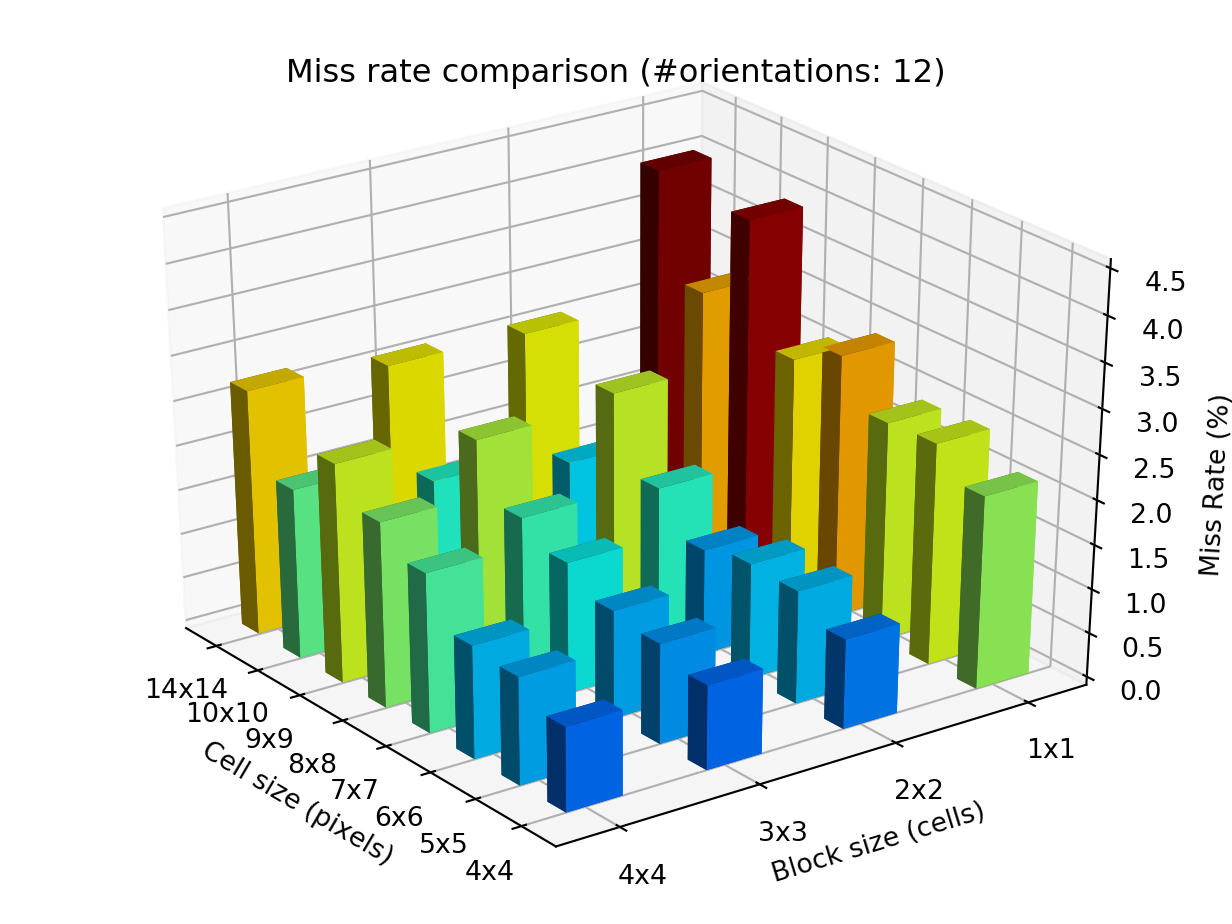

In [118]:
# plot 3D: (cell size, block size, miss rate) for fixed orientation
df_missrate3d = df.loc[df['Orientations']==best_orientations]
df_missrate3d = df_missrate3d.loc[:, ['Pixels per Cell', 'Cells per Block', 'Miss Rate']]

z_lim_min = 0
z_lim_max = 4.5
cellsize_labels = str_dim(df_missrate3d['Pixels per Cell'].unique())
blocksize_labels = str_dim(df_missrate3d['Cells per Block'].unique())
dz_np = df_missrate3d['Miss Rate'] * 100 - z_lim_min

fig, ax1 = plot_bar3d(cellsize_labels, blocksize_labels, dz_np, z_lim_min, z_lim_max,
                      'Cell size (pixels)', 'Block size (cells)', 'Miss Rate (%)', 
                      'Miss rate comparison (#orientations: {})'.format(int(best_orientations)))
ax1.view_init(elev=30, azim=144)
plt.show()

In [119]:
print('Max miss rate:')
print(df_missrate3d.loc[df_missrate3d['Miss Rate'].idxmax()])
print('\nMin miss rate:')
print(df_missrate3d.loc[df_missrate3d['Miss Rate'].idxmin()])
#df_missrate3d

Max miss rate:
Pixels per Cell    14.000000
Cells per Block     1.000000
Miss Rate           0.040498
Name: 39, dtype: float64

Min miss rate:
Pixels per Cell    4.000000
Cells per Block    3.000000
Miss Rate          0.009546
Name: 84, dtype: float64


### Maximise Accuracy

<IPython.core.display.Javascript object>


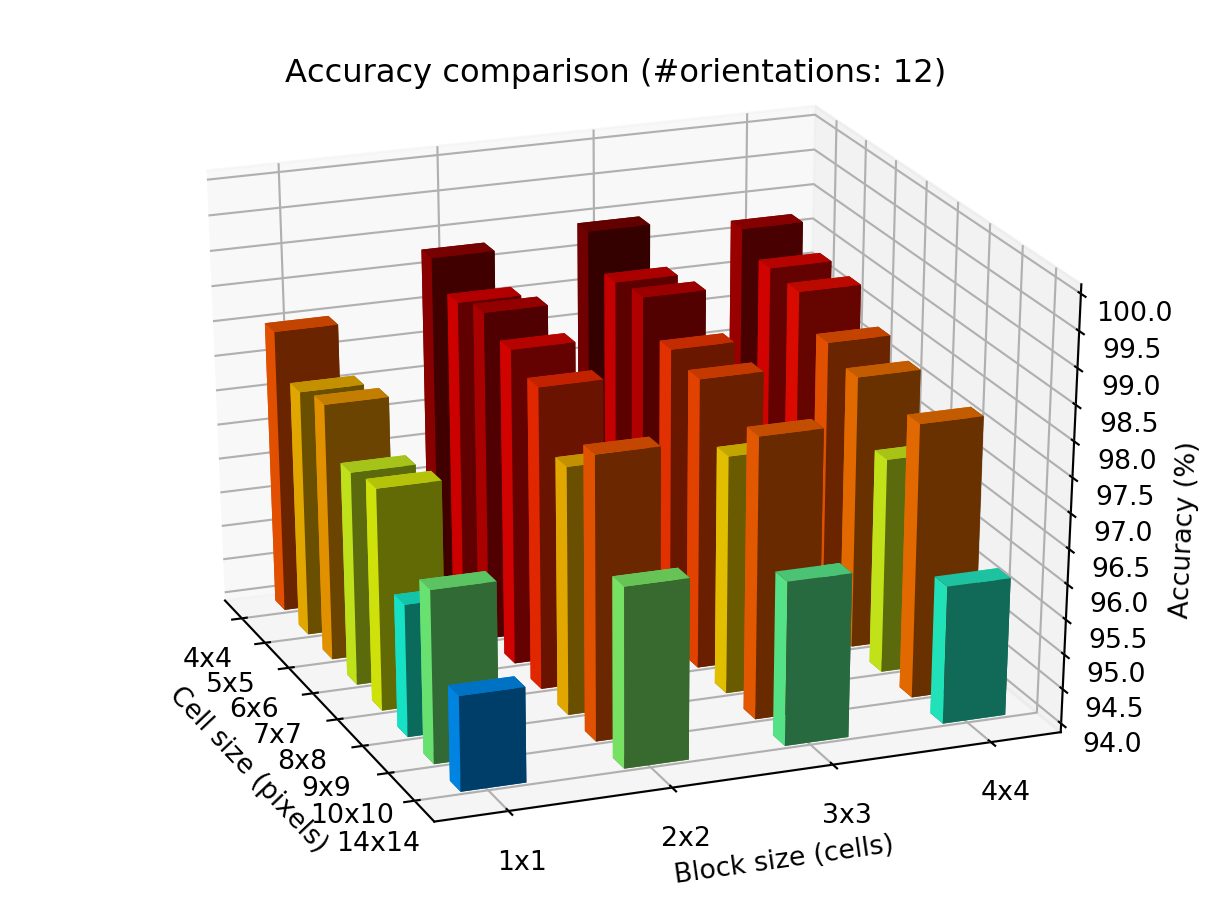

In [120]:
# plot 3D: (cell size, block size, accuracy) for fixed orientation
df_accuracy3d = df.loc[df['Orientations']==best_orientations]
df_accuracy3d = df_accuracy3d.loc[:, ['Pixels per Cell', 'Cells per Block', 'Accuracy']]

z_lim_min = 94
z_lim_max = 100
cellsize_labels = str_dim(df_accuracy3d['Pixels per Cell'].unique())
blocksize_labels = str_dim(df_accuracy3d['Cells per Block'].unique())
dz_np = df_accuracy3d['Accuracy'] * 100 - z_lim_min

fig, ax1 = plot_bar3d(cellsize_labels, blocksize_labels, dz_np, z_lim_min, z_lim_max, 
                      'Cell size (pixels)', 'Block size (cells)', 'Accuracy (%)', 
                      'Accuracy comparison (#orientations: {})'.format(int(best_orientations)))

ax1.view_init(elev=26, azim=-21)
plt.show()

# # (x,y,z) coordinates of each bar
# z_lim_min = 94
# x = list(range(len(cellsize_labels))) * int(len(df_accuracy3d)/len(cellsize_labels))
# y = [v for v in list(range(len(blocksize_labels))) for i in range(int(len(df_accuracy3d)/len(blocksize_labels)))]
# z = [0] * len(df_accuracy3d)
# # (width,depth,height) of each bar
# thickness = 0.4
# dx = [thickness] * len(df_accuracy3d)
# dy = [thickness] * len(df_accuracy3d)
# dz_np = df_accuracy3d['Accuracy'] * 100 - z_lim_min
# dz = list(dz_np)

# colors = plt.cm.jet(dz_np/dz_np.max())

# fig = plt.figure() # OOP style
# ax1 = fig.add_subplot(111, projection='3d')
# ax1.bar3d(x,y,z,dx,dy,dz,color=colors)

# tick_offset = thickness/2
# ztick_increment = 0.5
# ticksx = np.arange(tick_offset, len(cellsize_labels), 1)
# plt.xticks(ticksx, cellsize_labels)
# ticksy = np.arange(tick_offset, len(blocksize_labels), 1)
# plt.yticks(ticksy, blocksize_labels)
# ticksz = np.arange(0,100-z_lim_min+ztick_increment,ztick_increment)
# ticksz_labels = list(map(lambda v: '{:.1f}'.format(v), np.linspace(z_lim_min, 100, num=len(ticksz))))
# ax1.set_zticks(ticksz)
# ax1.set_zticklabels(ticksz_labels)

# ax1.set_xlabel('Cell size (pixels)')
# ax1.set_ylabel('Block size (cells)')
# ax1.set_zlabel('Accuracy (%)')
# ax1.set_title('Accuracy comparison (#orientations: {})'.format(int(best_orientations)))

# fig.tight_layout()
# plt.show()

In [121]:
print('Max accuracy:')
print(df_accuracy3d.loc[df_accuracy3d['Accuracy'].idxmax()])
print('\nMin accuracy:')
print(df_accuracy3d.loc[df_accuracy3d['Accuracy'].idxmin()])
#df_accuracy3d

Max accuracy:
Pixels per Cell    4.000000
Cells per Block    3.000000
Accuracy           0.989955
Name: 84, dtype: float64

Min accuracy:
Pixels per Cell    14.000000
Cells per Block     1.000000
Accuracy            0.953579
Name: 39, dtype: float64


### Maximise AUC

<IPython.core.display.Javascript object>


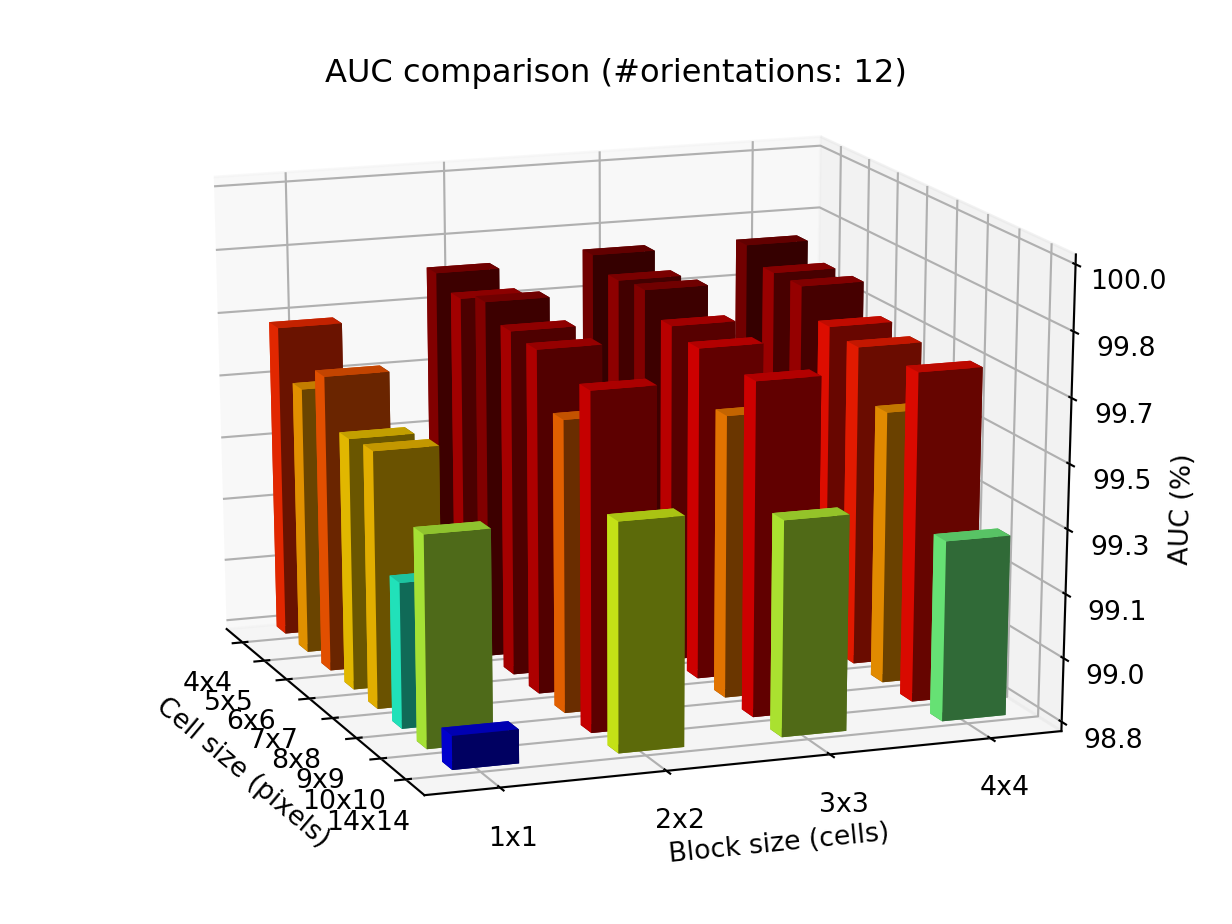

In [127]:
df_auc3d = df.loc[df['Orientations']==best_orientations]
df_auc3d = df_auc3d.loc[:, ['Pixels per Cell', 'Cells per Block', 'AUC']]

z_lim_min = 98.8
z_lim_max = 100
cellsize_labels = str_dim(df_auc3d['Pixels per Cell'].unique())
blocksize_labels = str_dim(df_auc3d['Cells per Block'].unique())
dz_np = df_auc3d['AUC'] * 100 - z_lim_min

fig, ax1 = plot_bar3d(cellsize_labels, blocksize_labels, dz_np, z_lim_min, z_lim_max, 
                      'Cell size (pixels)', 'Block size (cells)', 'AUC (%)', 
                      'AUC comparison (#orientations: {})'.format(int(best_orientations)),
                      ztick_increment=0.2)

ax1.view_init(elev=18, azim=-20)
plt.show()

In [123]:
print('Max AUC:')
print(df_auc3d.loc[df_auc3d['AUC'].idxmax()])
print('\nMin AUC:')
print(df_auc3d.loc[df_auc3d['AUC'].idxmin()])

Max AUC:
Pixels per Cell    4.000000
Cells per Block    3.000000
AUC                0.999455
Name: 84, dtype: float64

Min AUC:
Pixels per Cell    14.000000
Cells per Block     1.000000
AUC                 0.989052
Name: 39, dtype: float64


### Feature Vector Size 

<IPython.core.display.Javascript object>


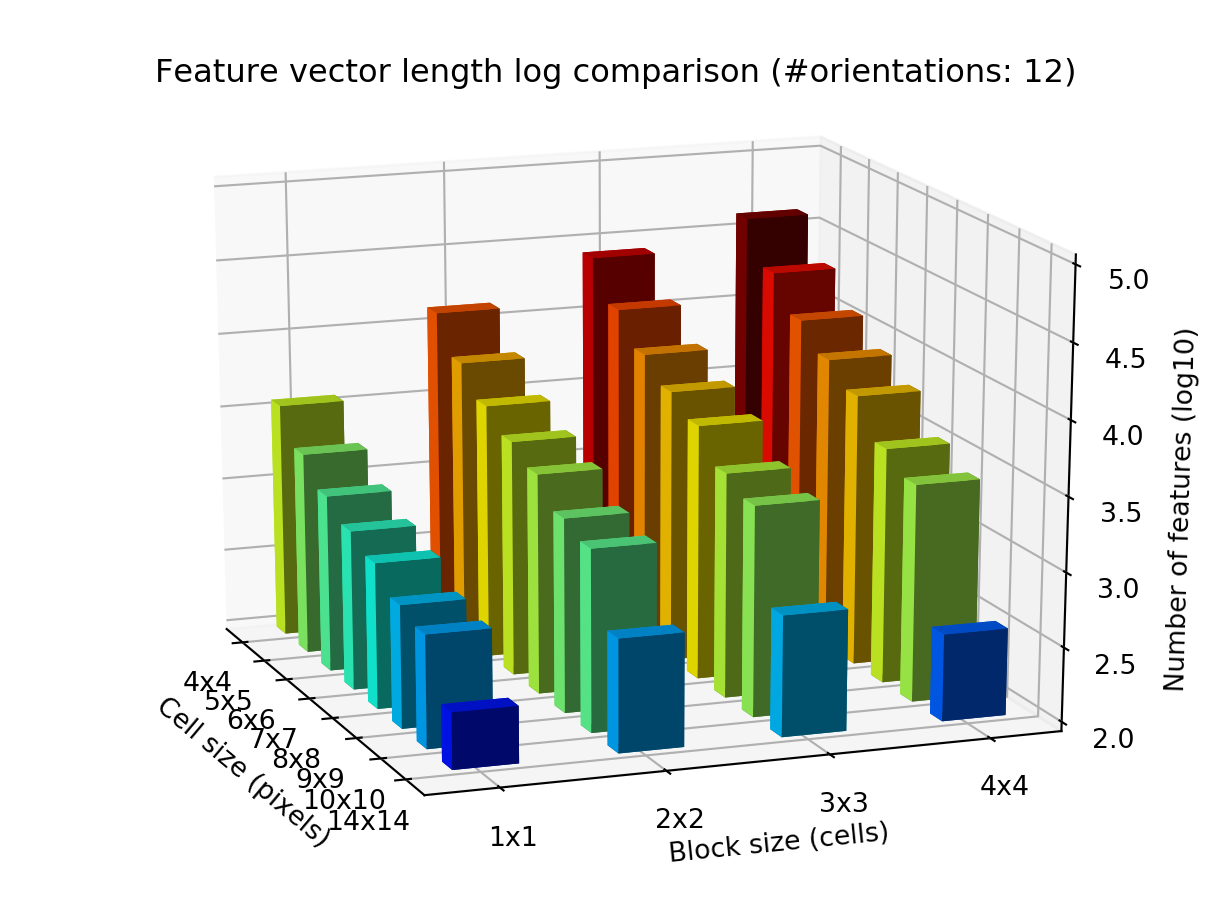

In [133]:
df_hog3d = df.loc[df['Orientations']==best_orientations]
df_hog3d = df_hog3d.loc[:, ['Pixels per Cell', 'Cells per Block', 'Feature Size']]

z_lim_min = 2
z_lim_max = 5
ztick_increment = 0.5

# (non-log10 scale parameters)
#z_lim_max = 50000  
#ztick_increment = 10000

cellsize_labels = str_dim(df_hog3d['Pixels per Cell'].unique())
blocksize_labels = str_dim(df_hog3d['Cells per Block'].unique())
dz_np = np.log10(df_hog3d['Feature Size']) - z_lim_min

fig, ax1 = plot_bar3d(cellsize_labels, blocksize_labels, dz_np, z_lim_min, z_lim_max, 
                      'Cell size (pixels)', 'Block size (cells)', 'Number of features (log10)', 
                      'Feature vector length log comparison (#orientations: {})'.format(int(best_orientations)),
                      ztick_increment=ztick_increment)

ax1.view_init(elev=18, azim=-20)
plt.show()

In [129]:
print('Max FV length:')
print(df_hog3d.loc[df_hog3d['Feature Size'].idxmax()])
print('\nMin FV length:')
print(df_hog3d.loc[df_hog3d['Feature Size'].idxmin()])

Max FV length:
Pixels per Cell        4
Cells per Block        4
Feature Size       42432
Name: 124, dtype: int64

Min FV length:
Pixels per Cell     14
Cells per Block      1
Feature Size       240
Name: 39, dtype: int64


### Orientations Trend (for fixed block/cell size)

<IPython.core.display.Javascript object>


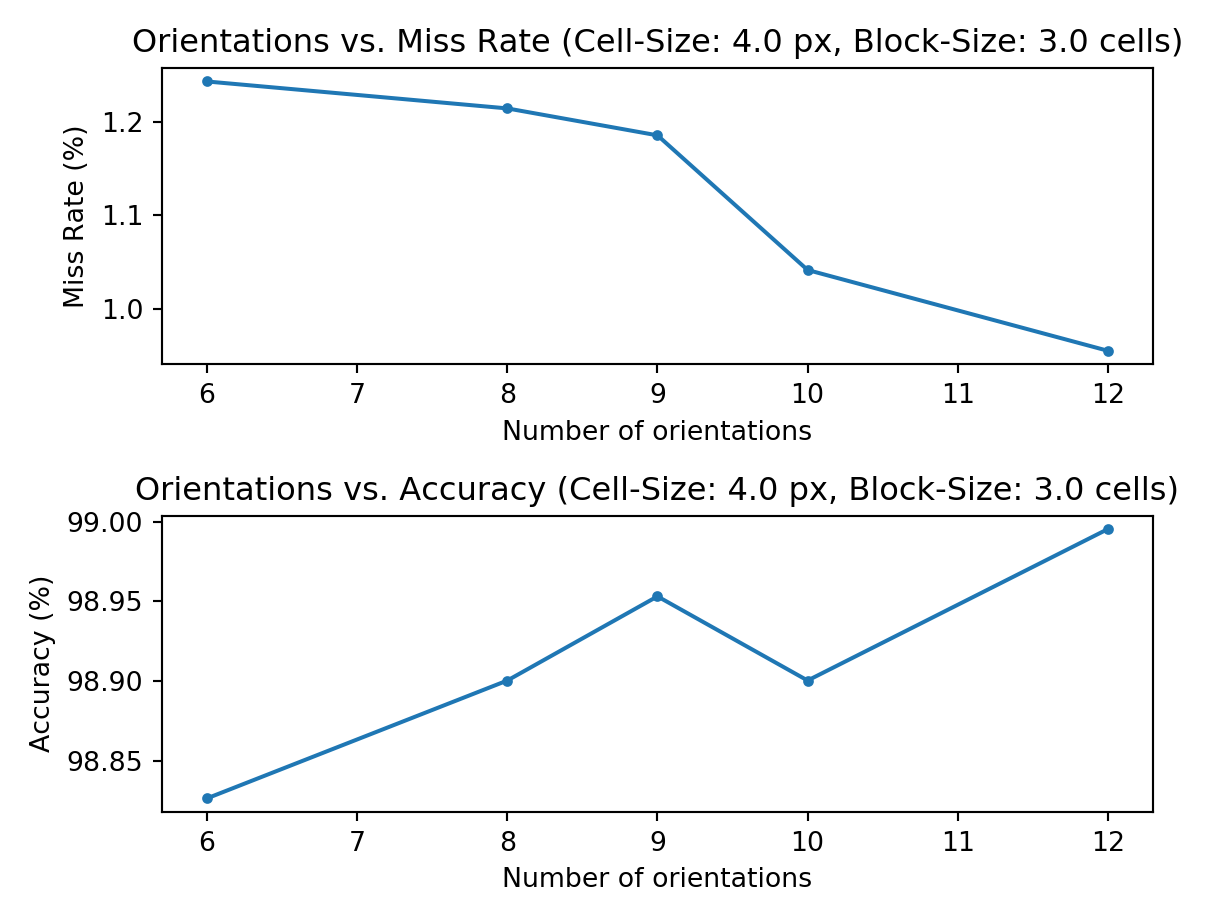

In [124]:
best_blocksize = max_accuracy_row.get(key='Cells per Block')
best_cellsize = max_accuracy_row.get(key='Pixels per Cell')

df_orientations = df.loc[(df['Cells per Block'] == best_blocksize) & (df['Pixels per Cell'] == best_cellsize)]
fig = plt.figure()
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
ax1.plot(df_orientations['Orientations'], df_orientations['Miss Rate'] * 100, marker='.')
ax1.set_xlabel('Number of orientations')
ax1.set_ylabel('Miss Rate (%)')
ax1.set_title('Orientations vs. Miss Rate (Cell-Size: {} px, Block-Size: {} cells)'.format(best_cellsize, best_blocksize))

ax2.plot(df_orientations['Orientations'], df_orientations['Accuracy'] * 100, marker='.')
ax2.set_xlabel('Number of orientations')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Orientations vs. Accuracy (Cell-Size: {} px, Block-Size: {} cells)'.format(best_cellsize, best_blocksize))

fig.tight_layout()
plt.show()

### Performance Statistics

In [125]:
dfp = pd.read_csv(CSV_POST_PERFORMANCE_FILE)
dfp = pd.merge(df, dfp, how='left', on=['Cells per Block','Pixels per Cell','Orientations'])
print('Null values:\n' + str(np.sum(dfp.isna())))
dfp

Null values:
Test                            0
Cells per Block                 0
Pixels per Cell                 0
Orientations                    0
Feature Size                    0
AUC                             0
Accuracy                        0
Precision                       0
Recall                          0
Training Accuracy               0
Prediction Time (s)             0
TP                              0
TN                              0
FP                              0
FN                              0
Miss Rate                       0
HOG Processing Time (s)         0
Training Time (s)               0
Training Pickle Size (bytes)    0
dtype: int64


,Test,Cells per Block,Pixels per Cell,Orientations,Feature Size,AUC,Accuracy,Precision,Recall,Training Accuracy,Prediction Time (s),TP,TN,FP,FN,Miss Rate,HOG Processing Time (s),Training Time (s),Training Pickle Size (bytes)
0,1,1,4,6,1920,0.996012,0.974410,0.974472,0.974410,1.000000,0.382794,3350,5865,135,107,0.030952,42.006,6.046,79843
1,2,1,4,8,2560,0.997329,0.978640,0.978680,0.978640,1.000000,0.438810,3367,5888,112,90,0.026034,43.547,4.787,105443
2,3,1,4,9,2880,0.996937,0.978323,0.978361,0.978323,1.000000,0.522411,3365,5887,113,92,0.026613,45.060,5.266,118243
3,4,1,4,10,3200,0.997586,0.980332,0.980374,0.980332,1.000000,0.573908,3376,5895,105,81,0.023431,43.065,4.234,131043
4,5,1,4,12,3840,0.997873,0.980755,0.980816,0.980755,1.000000,0.671648,3382,5893,107,75,0.021695,230.954,4.266,156643
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,156,4,14,6,192,0.986252,0.945332,0.946838,0.945332,0.956500,0.031246,3299,5641,359,158,0.045704,9.776,0.527,10718
156,157,4,14,8,256,0.991834,0.955588,0.956980,0.955588,0.964667,0.054459,3347,5690,310,110,0.031819,9.698,0.682,13283
157,158,4,14,9,288,0.992339,0.957809,0.959059,0.957809,0.968667,0.046865,3352,5706,294,105,0.030373,9.132,0.710,14563
158,159,4,14,10,320,0.993277,0.959818,0.961039,0.959818,0.968667,0.046867,3361,5716,284,96,0.027770,9.494,0.685,15843
